# Task 1 Evaluation

This notebook contains the evaluation for Task 1 of the TREC Fair Ranking track.

In [1]:
DATA_MODE = 'eval'

In [2]:
import wptrec
wptrec.DATA_MODE = DATA_MODE

## Setup

We begin by loading necessary libraries:

In [3]:
from pathlib import Path
import pandas as pd
import numpy as np
import xarray as xr
from scipy.stats import bootstrap
import matplotlib.pyplot as plt
import seaborn as sns
import gzip
import binpickle

In [4]:
tbl_dir = Path('data/metric-tables')

Set up progress bar and logging support:

In [5]:
from tqdm.auto import tqdm
tqdm.pandas(leave=False)

In [6]:
import sys, logging
logging.basicConfig(level=logging.INFO, stream=sys.stderr)
log = logging.getLogger('task1-eval')

Set up the RNG:

In [7]:
import seedbank
seedbank.initialize(20220101)
rng = seedbank.numpy_rng()

INFO:seedbank:initialized root seed SeedSequence(
    entropy=20220101,
)


Import metric code:

In [8]:
%load_ext autoreload
%autoreload 2

In [9]:
import wptrec.metrics as metrics
from wptrec.trecdata import scan_runs

And finally import the metric itself.  For Task 1, this uses:

* evaluation qrels
* evaluation intersectional targets
* all dimensions (with their page alignments)

In [10]:
from MetricInputs import qrels, dimensions

INFO:MetricInputs:reading data\metric-tables\page-sub-geo-align.parquet
INFO:MetricInputs:reading data\metric-tables\page-src-geo-align.parquet
INFO:MetricInputs:reading data\metric-tables\page-gender-align.parquet
INFO:MetricInputs:reading data\metric-tables\page-occ-align.parquet
INFO:MetricInputs:reading data\metric-tables\page-alpha-align.parquet
INFO:MetricInputs:reading data\metric-tables\page-age-align.parquet
INFO:MetricInputs:reading data\metric-tables\page-pop-align.parquet
INFO:MetricInputs:reading data\metric-tables\page-langs-align.parquet


In [12]:
target = xr.open_dataarray(tbl_dir / f'task1-{DATA_MODE}-int-targets.nc')

In [13]:
metric = metrics.AWRFMetric(qrels.set_index('topic_id'), dimensions, target)

## Importing Data

Let's load the runs now:

In [14]:
runs = pd.DataFrame.from_records(row for rows in scan_runs(1, 'runs/2022') for row in rows)
runs

INFO:wptrec.trecdata:scanning runs\2022\coordinators\0mt5.gz
INFO:wptrec.trecdata:scanning runs\2022\coordinators\0mt5_p.gz
INFO:wptrec.trecdata:scanning runs\2022\coordinators\ans_bm25.gz
INFO:wptrec.trecdata:scanning runs\2022\coordinators\bm25_p.gz
INFO:wptrec.trecdata:scanning runs\2022\coordinators\FRT_attention.gz
INFO:wptrec.trecdata:scanning runs\2022\coordinators\FRT_constraint.gz
INFO:wptrec.trecdata:scanning runs\2022\coordinators\FRT_diversity.gz
INFO:wptrec.trecdata:scanning runs\2022\coordinators\rmit_cidda_ir_1.gz
INFO:wptrec.trecdata:scanning runs\2022\coordinators\rmit_cidda_ir_2.gz
INFO:wptrec.trecdata:scanning runs\2022\coordinators\rmit_cidda_ir_3.gz
INFO:wptrec.trecdata:scanning runs\2022\coordinators\rmit_cidda_ir_4.gz
INFO:wptrec.trecdata:scanning runs\2022\coordinators\rmit_cidda_ir_5.gz
INFO:wptrec.trecdata:scanning runs\2022\coordinators\rmit_cidda_ir_6.gz
INFO:wptrec.trecdata:scanning runs\2022\coordinators\rmit_cidda_ir_7.gz
INFO:wptrec.trecdata:scanning run

,run_name,topic_id,rank,page_id
0,0mt5,187,1,6386814
1,0mt5,187,2,41584565
2,0mt5,187,3,344140
3,0mt5,187,4,41524
4,0mt5,187,5,951540
...,...,...,...,...
634421,UoGTrT1ColPRF,2872,496,63163206
634422,UoGTrT1ColPRF,2872,497,61270927
634423,UoGTrT1ColPRF,2872,498,37529140
634424,UoGTrT1ColPRF,2872,499,33341560


## Computing Metrics

We are now ready to compute the metric for each (system,topic) pair.  Let's go!

In [32]:
rank_awrf = runs.groupby(['run_name', 'topic_id'])['page_id'].progress_apply(metric)
rank_awrf = rank_awrf.unstack()
rank_awrf

  0%|          | 0/1269 [00:00<?, ?it/s]

nDCG      AWRF     Score
run_name topic_id                              
0mt5     187       0.667769  0.457060  0.305211
         270       0.799233  0.386480  0.308888
         359       0.989338  0.457630  0.452750
         365       0.817444  0.445795  0.364412
         400       0.534107  0.445476  0.237932
...                     ...       ...       ...
tmt5_p   2448      0.422133  0.453943  0.191625
         2483      0.308426  0.399113  0.123097
         2758      0.606670  0.494592  0.300054
         2867      0.795330  0.471933  0.375342
         2872      0.170711  0.374910  0.064001

[1269 rows x 3 columns]

Make sure we aren't missing anything:

In [33]:
rank_awrf[rank_awrf['Score'].isnull()]

,,nDCG,AWRF,Score
run_name,topic_id,,,


Now let's average by runs:

In [34]:
run_scores = rank_awrf.groupby('run_name').mean()
run_scores.sort_values('Score', ascending=False, inplace=True)
run_scores

,nDCG,AWRF,Score
run_name,,,
tmt5,0.724215,0.498812,0.362626
UoGRelvOnlyT1,0.604420,0.524572,0.325393
UoGTrT1ColPRF,0.604420,0.524572,0.325393
UoGTrExpE2,0.597741,0.524305,0.322974
0mt5,0.621612,0.477848,0.298972
0mt5_p,0.584138,0.501518,0.294887
tmt5_p,0.572786,0.512117,0.294553
FRT_constraint,0.574858,0.479295,0.278210
bm25_p,0.543421,0.502616,0.277292


And bootstrap some confidence intervals:

In [35]:
def boot_ci(col):
    res = bootstrap([col], statistic=np.mean, random_state=rng)
    return pd.Series({
        'Score.SE': res.standard_error,
        'Score.Lo': res.confidence_interval.low,
        'Score.Hi': res.confidence_interval.high,
        'Score.W': res.confidence_interval.high - res.confidence_interval.low
    })

In [36]:
run_score_ci = rank_awrf.groupby('run_name')['Score'].apply(boot_ci).unstack()
run_score_ci

,Score.SE,Score.Lo,Score.Hi,Score.W
run_name,,,,
0mt5,0.016592,0.267008,0.332377,0.065369
0mt5_p,0.016398,0.261747,0.325884,0.064137
FRT_attention,0.020430,0.230604,0.310667,0.080063
FRT_constraint,0.017376,0.244757,0.312472,0.067715
FRT_diversity,0.017664,0.229278,0.298951,0.069673
UDInfo_F_bm25,0.017142,0.236455,0.302441,0.065986
UDInfo_F_lgbm2,0.017101,0.235019,0.302140,0.067121
UDInfo_F_lgbm4,0.017008,0.234740,0.301601,0.066861
UDInfo_F_mlp2,0.017145,0.235353,0.302400,0.067047


In [37]:
run_score_full = run_scores.join(run_score_ci)
run_score_full

,nDCG,AWRF,Score,Score.SE,Score.Lo,Score.Hi,Score.W
run_name,,,,,,,
tmt5,0.724215,0.498812,0.362626,0.018015,0.326058,0.396537,0.070480
UoGRelvOnlyT1,0.604420,0.524572,0.325393,0.022218,0.283661,0.371586,0.087925
UoGTrT1ColPRF,0.604420,0.524572,0.325393,0.021808,0.283034,0.368779,0.085745
UoGTrExpE2,0.597741,0.524305,0.322974,0.022461,0.280328,0.368213,0.087885
0mt5,0.621612,0.477848,0.298972,0.016592,0.267008,0.332377,0.065369
0mt5_p,0.584138,0.501518,0.294887,0.016398,0.261747,0.325884,0.064137
tmt5_p,0.572786,0.512117,0.294553,0.017021,0.260106,0.327232,0.067125
FRT_constraint,0.574858,0.479295,0.278210,0.017376,0.244757,0.312472,0.067715
bm25_p,0.543421,0.502616,0.277292,0.017945,0.241094,0.311921,0.070827


In [38]:
run_tbl_df = run_score_full[['nDCG', 'AWRF', 'Score']].copy()
run_tbl_df['95% CI'] = run_score_full.apply(lambda r: "(%.3f, %.3f)" % (r['Score.Lo'], r['Score.Hi']), axis=1)
run_tbl_df

,nDCG,AWRF,Score,95% CI
run_name,,,,
tmt5,0.724215,0.498812,0.362626,"(0.326, 0.397)"
UoGRelvOnlyT1,0.604420,0.524572,0.325393,"(0.284, 0.372)"
UoGTrT1ColPRF,0.604420,0.524572,0.325393,"(0.283, 0.369)"
UoGTrExpE2,0.597741,0.524305,0.322974,"(0.280, 0.368)"
0mt5,0.621612,0.477848,0.298972,"(0.267, 0.332)"
0mt5_p,0.584138,0.501518,0.294887,"(0.262, 0.326)"
tmt5_p,0.572786,0.512117,0.294553,"(0.260, 0.327)"
FRT_constraint,0.574858,0.479295,0.278210,"(0.245, 0.312)"
bm25_p,0.543421,0.502616,0.277292,"(0.241, 0.312)"


Combine them:

In [39]:
run_tbl_fn = Path('figures/task1-runs.tex')
run_tbl = run_tbl_df.to_latex(float_format="%.4f", bold_rows=True, index_names=False)
run_tbl_fn.write_text(run_tbl)
print(run_tbl)

\begin{tabular}{lrrrl}
\toprule
{} &   nDCG &   AWRF &  Score &          95\% CI \\
\midrule
\textbf{tmt5           } & 0.7242 & 0.4988 & 0.3626 &  (0.326, 0.397) \\
\textbf{UoGRelvOnlyT1  } & 0.6044 & 0.5246 & 0.3254 &  (0.284, 0.372) \\
\textbf{UoGTrT1ColPRF  } & 0.6044 & 0.5246 & 0.3254 &  (0.283, 0.369) \\
\textbf{UoGTrExpE2     } & 0.5977 & 0.5243 & 0.3230 &  (0.280, 0.368) \\
\textbf{0mt5           } & 0.6216 & 0.4778 & 0.2990 &  (0.267, 0.332) \\
\textbf{0mt5\_p         } & 0.5841 & 0.5015 & 0.2949 &  (0.262, 0.326) \\
\textbf{tmt5\_p         } & 0.5728 & 0.5121 & 0.2946 &  (0.260, 0.327) \\
\textbf{FRT\_constraint } & 0.5749 & 0.4793 & 0.2782 &  (0.245, 0.312) \\
\textbf{bm25\_p         } & 0.5434 & 0.5026 & 0.2773 &  (0.241, 0.312) \\
\textbf{UoGTrQE        } & 0.5368 & 0.4983 & 0.2734 &  (0.240, 0.309) \\
\textbf{UoGTrExpE1     } & 0.5176 & 0.5122 & 0.2716 &  (0.238, 0.308) \\
\textbf{UDInfo\_F\_bm25  } & 0.5666 & 0.4719 & 0.2708 &  (0.236, 0.302) \\
\textbf{ans\_bm25       }

C:\Users\michaelekstrand\AppData\Local\Temp\ipykernel_31016\1760839561.py:2: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  run_tbl = run_tbl_df.to_latex(float_format="%.4f", bold_rows=True, index_names=False)


## Analyzing Scores

What is the distribution of scores?

In [40]:
run_scores.describe()

,nDCG,AWRF,Score
count,27.000000,27.000000,27.000000
mean,0.565801,0.477424,0.274720
std,0.041976,0.028173,0.031288
min,0.517629,0.441563,0.234528
25%,0.537502,0.447654,0.245884
50%,0.563832,0.471891,0.270307
75%,0.579498,0.500165,0.286381
max,0.724215,0.524572,0.362626


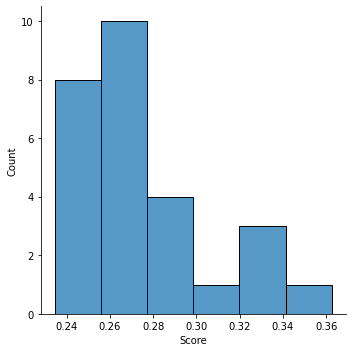

In [41]:
sns.displot(x='Score', data=run_scores)
plt.savefig('figures/task1-score-dist.pdf')
plt.show()

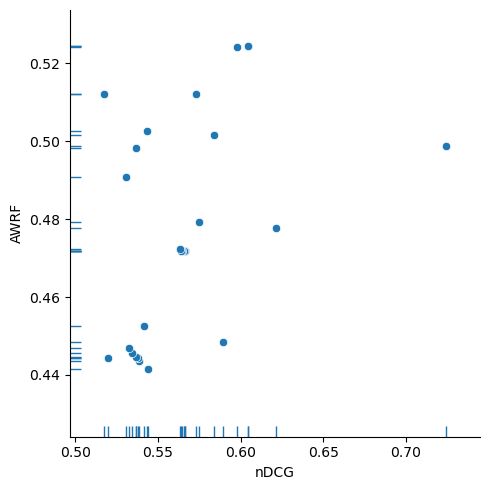

In [42]:
sns.relplot(x='nDCG', y='AWRF', data=run_scores)
sns.rugplot(x='nDCG', y='AWRF', data=run_scores)
plt.savefig('figures/task1-ndcg-awrf.pdf')
plt.show()

## Per-Topic Stats

We need to return per-topic stats to each participant, at least for the score.

In [43]:
topic_stats = rank_awrf.groupby('topic_id').agg(['mean', 'median', 'min', 'max'])
topic_stats

nDCG                                    AWRF            \
              mean    median       min       max      mean    median   
topic_id                                                               
187       0.671795  0.672085  0.548761  0.858201  0.470965  0.473087   
270       0.502570  0.466971  0.145578  0.998345  0.389207  0.374764   
359       0.966639  0.993030  0.790074  1.000000  0.474250  0.457917   
365       0.748363  0.793391  0.405873  0.909642  0.442687  0.445795   
400       0.330756  0.381396  0.010630  0.565108  0.393360  0.403479   
404       0.160442  0.078093  0.019550  0.869137  0.330611  0.318326   
480       0.510201  0.468939  0.225929  0.908334  0.592818  0.585420   
517       0.526972  0.528756  0.211103  0.793948  0.463862  0.447951   
568       0.556587  0.639295  0.243191  0.785961  0.437757  0.449493   
596       0.377157  0.353265  0.270219  0.646304  0.649003  0.642541   
715       0.663360  0.664162  0.567567  0.758623  0.534521  0.525028   
807       0.466344  0.404662  0.361982  0.798883  0.507620  0.494374   
834       0.385957  0.371457  0.140336  0.645218  0.521612  0.516596   
881       0.727160  0.667201  0.541410  0.953894  0.451447  0.446781   
883       0.530776  0.534697  0.282823  0.734253  0.518868  0.525345   
949       0.631990  0.625556  0.459121  0.732711  0.509191  0.516788   
951       0.170911  0.150893  0.116567  0.278621  0.531245  0.524732   
955       0.587363  0.525712  0.171094  0.965386  0.428591  0.408763   
995       0.737838  0.714714  0.608271  0.969748  0.604650  0.584533   
1018      0.886481  0.992671  0.308286  1.000000  0.352658  0.345841   
1180      0.823926  0.891650  0.489603  0.973290  0.486638  0.477741   
1233      0.937414  0.979405  0.600071  0.995067  0.478171  0.471630   
1328      0.592772  0.650831  0.310299  0.711581  0.505011  0.503317   
1406      0.841039  0.828776  0.606231  0.921841  0.570119  0.562728   
1417      0.419480  0.362293  0.206167  0.621883  0.412297  0.396386   
1448      0.899945  0.928486  0.664956  0.943179  0.499268  0.500253   
1479      0.619679  0.620241  0.516940  0.831911  0.531988  0.534366   
1548      0.617256  0.621620  0.410360  0.798556  0.421553  0.415746   
1558      0.417449  0.392551  0.313015  0.568934  0.593472  0.588820   
1647      0.671100  0.672802  0.227833  0.903670  0.485823  0.490120   
1806      0.548551  0.548452  0.463345  0.619783  0.487249  0.484384   
1821      0.173915  0.185269  0.027156  0.315185  0.391730  0.390756   
1877      0.673956  0.691925  0.366736  0.998261  0.349548  0.347272   
1884      0.301335  0.192760  0.110107  0.910519  0.470015  0.470478   
1890      0.640006  0.691971  0.226843  0.744391  0.543962  0.554280   
2000      0.578723  0.592374  0.441846  0.688756  0.509634  0.506232   
2028      0.407982  0.390481  0.279947  0.563339  0.499397  0.509892   
2106      0.468100  0.443124  0.230731  0.842568  0.453687  0.450181   
2153      0.650662  0.674955  0.375659  0.926114  0.540212  0.545599   
2160      0.635771  0.628778  0.526408  0.869780  0.518737  0.511960   
2229      0.706088  0.715386  0.542750  0.852896  0.501106  0.494573   
2244      0.463273  0.536992  0.195189  0.978452  0.480807  0.452926   
2448      0.490861  0.457402  0.359331  0.686117  0.440695  0.433107   
2483      0.419461  0.344833  0.214200  0.692918  0.413979  0.393228   
2758      0.643616  0.691164  0.376169  0.782704  0.451428  0.457079   
2867      0.571066  0.607342  0.198402  0.967670  0.428758  0.435471   
2872      0.239577  0.201389  0.072036  0.586014  0.368700  0.357666   

                                 Score                                
               min       max      mean    median       min       max  
topic_id                                                              
187       0.422491  0.512018  0.315716  0.312819  0.274254  0.413414  
270       0.352574  0.469519  0.200771  0.170491  0.054557  0.389074  
359       0.442714  0.529432  0.457817  0.453622  0.380284

Make final score analysis:

In [44]:
topic_range = topic_stats.loc[:, 'Score']
topic_range = topic_range.drop(columns=['mean'])
topic_range

,median,min,max
topic_id,,,
187,0.312819,0.274254,0.413414
270,0.170491,0.054557,0.389074
359,0.453622,0.380284,0.523354
365,0.357560,0.175290,0.383288
400,0.164437,0.003379,0.252168
404,0.024859,0.006171,0.384851
480,0.275639,0.109474,0.628577
517,0.231764,0.086068,0.446546
568,0.285049,0.103372,0.367828


And now we combine scores with these results to return to participants.

In [46]:
ret_dir = Path('results') / 'coordinators'
ret_dir.mkdir(exist_ok=True)
for system, runs in rank_awrf.groupby('run_name'):
    aug = runs.join(topic_range).reset_index().drop(columns=['run_name'])
    fn = ret_dir / f'{system}.tsv'
    log.info('writing %s', fn)
    aug.to_csv(fn, sep='\t', index=False)

INFO:task1-eval:writing results\coordinators\0mt5.tsv
INFO:task1-eval:writing results\coordinators\0mt5_p.tsv
INFO:task1-eval:writing results\coordinators\FRT_attention.tsv
INFO:task1-eval:writing results\coordinators\FRT_constraint.tsv
INFO:task1-eval:writing results\coordinators\FRT_diversity.tsv
INFO:task1-eval:writing results\coordinators\UDInfo_F_bm25.tsv
INFO:task1-eval:writing results\coordinators\UDInfo_F_lgbm2.tsv
INFO:task1-eval:writing results\coordinators\UDInfo_F_lgbm4.tsv
INFO:task1-eval:writing results\coordinators\UDInfo_F_mlp2.tsv
INFO:task1-eval:writing results\coordinators\UDInfo_F_mlp4.tsv
INFO:task1-eval:writing results\coordinators\UoGRelvOnlyT1.tsv
INFO:task1-eval:writing results\coordinators\UoGTrExpE1.tsv
INFO:task1-eval:writing results\coordinators\UoGTrExpE2.tsv
INFO:task1-eval:writing results\coordinators\UoGTrQE.tsv
INFO:task1-eval:writing results\coordinators\UoGTrT1ColPRF.tsv
INFO:task1-eval:writing results\coordinators\ans_bm25.tsv
INFO:task1-eval:writin